# SETANDO ALTERACOES

In [25]:
import os

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from dotenv import load_dotenv

import datetime
from dateutil import relativedelta

import streamlit as st

load_dotenv()

try:

    df_brasileiro_cards = pd.read_csv(os.getenv('BRASILEIRO_CARTOES'))
    df_brasileiro_full = pd.read_csv(os.getenv('BRASILEIRO_FULL')) # PARTIDAS
    df_brasileiro_stats = pd.read_csv(os.getenv('BRASILEIRO_ESTATISTICAS'))
    df_brasileiro_gols = pd.read_csv(os.getenv('BRASILEIRO_GOLS'))

except:
    raise FileExistsError('Could not find database file')

df_fla_stats = df_brasileiro_stats.query("clube == 'Flamengo'")
df_fla_gols = df_brasileiro_gols.query("clube == 'Flamengo'")
df_fla_cards = df_brasileiro_cards.query("clube == 'Flamengo'")
df_fla_jogos = df_brasileiro_full.query("mandante == 'Flamengo' or visitante == 'Flamengo'")

#PEGANDO UNIDO AS ESTATÍSTICAS COM OS JOGOS E REMOVENDO DADOS COM CAMPOS VAZIOS
df_fla_jogos = df_fla_jogos.rename(columns={'ID':'partida_id'})
df_jogos_stats = pd.merge(df_fla_jogos, df_fla_stats, how = "left", on="partida_id")


df_jogos_stats = (
                    df_jogos_stats
                    .dropna()
                    .drop(['rodata_y'], axis = 1)
                    .rename(columns = {'rodata_x': 'rodata'})
                )

# TRAZENDO OS CAMPOS DE INTERESSE
df_fla_placar = df_jogos_stats[['partida_id', 'data','mandante','visitante','tecnico_visitante', 'tecnico_mandante','mandante_Placar','visitante_Placar','arena','formacao_mandante', 'formacao_visitante']]

# ADICINANDO COLUNA PARA FAZER O HISTÓRICO ANUAL

df_fla_placar = (
    df_fla_placar
    .assign(ano = pd.to_datetime(df_fla_placar['data']).dt.year)
    .assign(mes = pd.to_datetime(df_fla_placar['data']).dt.month)
    .assign(mensal_overview = pd.to_datetime(df_fla_placar["data"]))
    .assign(resultado = np.where(
                                    (df_fla_placar['mandante_Placar'] > df_fla_placar['visitante_Placar']) & (df_fla_placar['mandante'] == "Flamengo"), 'Vitoria',
                                    np.where(
                                        (df_fla_placar['mandante_Placar'] > df_fla_placar['visitante_Placar']) & (df_fla_placar['mandante'] != "Flamengo"), 'Derrota',
                                    np.where(
                                        (df_fla_placar['visitante_Placar'] > df_fla_placar['mandante_Placar']) & (df_fla_placar['mandante'] == "Flamengo"), 'Derrota',
                                    np.where(
                                        (df_fla_placar['visitante_Placar'] > df_fla_placar['mandante_Placar']) & (df_fla_placar['mandante'] != "Flamengo"), 'Vitoria', 'Empate'
                                    )))))
    .assign(oponente = np.where(df_fla_placar['mandante'] == 'Flamengo', df_fla_placar['visitante'], df_fla_placar['mandante']))
    .assign(cont_partidas = 1)
)

# FAZENDO A CONTAGEM DE RESULTADOS DO TIME

df_fla_placar = (
    df_fla_placar
    .assign(cont_empates = np.where(df_fla_placar['resultado'] == "Empate",1,0))
    .assign(cont_vitorias = np.where(df_fla_placar['resultado'] == "Vitoria",1,0))
    .assign(cont_derrotas = np.where(df_fla_placar['resultado'] == "Derrota",1,0))
    .assign(tecnico= np.where(df_fla_placar["mandante"] == "Flamengo", df_fla_placar["tecnico_mandante"], df_fla_placar["tecnico_visitante"]))
)

df_fla_placar["mensal_overview"] = df_fla_placar["mensal_overview"].apply(lambda x: x.replace(day = 1))

# fig, ax = plt.subplots()

# sns.set(style="dark", rc={
#     'axes.facecolor': 'gray',     # Fundo dos eixos
#     'figure.facecolor': 'black',   # Fundo da figura
#     'axes.edgecolor': 'white',     # Cor da borda dos eixos
#     'grid.color': 'gray',          # Cor da grade
#     'xtick.color': 'white',        # Cor dos ticks no eixo x
#     'ytick.color': 'white',        # Cor dos ticks no eixo y
#     'axes.labelcolor': 'white',    # Cor dos rótulos dos eixos
#     'text.color': 'white'          # Cor do texto
# })

# # sns.set(
# #     style="dark", rc = {
# #     "axes.facecolor": "black",
# #     "figure.facecolor": "black"
# #     }
# # )
# sns.lineplot(x='ano', y = 'derrotas', data = df_fla_overview_ano, ax = ax)
# # ax.set_box_aspect(aspect=0.5)
# ax.set_title('Vitorias - Ano')
df_fla_placar


C:\Users\joaop\AppData\Local\Temp\ipykernel_1088\3420731750.py:51: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  .assign(ano = pd.to_datetime(df_fla_placar['data']).dt.year)
C:\Users\joaop\AppData\Local\Temp\ipykernel_1088\3420731750.py:52: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  .assign(mes = pd.to_datetime(df_fla_placar['data']).dt.month)
C:\Users\joaop\AppData\Local\Temp\ipykernel_1088\3420731750.py:53: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  .assign(mensal_overview = pd.to_datetime(df_fla_placar["data"]))


,partida_id,data,mandante,visitante,tecnico_visitante,tecnico_mandante,mandante_Placar,visitante_Placar,arena,formacao_mandante,...,ano,mes,mensal_overview,resultado,oponente,cont_partidas,cont_empates,cont_vitorias,cont_derrotas,tecnico
590,6127,14/04/2018,Vitoria,Flamengo,M. Nogueira Barbieri,V. Carmo Mancini,2,2,Barradão,4-2-3-1,...,2018,4,2018-04-01,Empate,Vitoria,1,1,0,0,M. Nogueira Barbieri
591,6137,21/04/2018,Flamengo,America-MG,E. Alves Moreira,M. Nogueira Barbieri,2,0,Maracanã,4-1-4-1,...,2018,4,2018-04-01,Vitoria,America-MG,1,0,1,0,M. Nogueira Barbieri
592,6148,29/04/2018,Ceara,Flamengo,M. Nogueira Barbieri,M. Oliveira Chamusca,0,3,Arena Castelão,3-4-2-1,...,2018,4,2018-04-01,Vitoria,Ceara,1,0,1,0,M. Nogueira Barbieri
593,6159,06/05/2018,Flamengo,Internacional,O. Hellmann,M. Nogueira Barbieri,2,0,Maracanã,4-1-4-1,...,2018,5,2018-05-01,Vitoria,Internacional,1,0,1,0,M. Nogueira Barbieri
594,6172,13/05/2018,Chapecoense,Flamengo,M. Nogueira Barbieri,G. Kleina,3,2,Arena Condá,4-1-4-1,...,2018,5,2018-05-01,Derrota,Chapecoense,1,0,0,1,M. Nogueira Barbieri
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
813,8325,23/11/2023,Flamengo,Bragantino,P. Faria Caixinha,A. Bacchi,1,0,Maracanã,4-2-3-1,...,2023,11,2023-11-01,Vitoria,Bragantino,1,0,1,0,A. Bacchi
814,8371,26/11/2023,America-MG,Flamengo,A. Bacchi,D. Giacomini,0,3,Estádio Municipal Parque do Sabiá,4-2-3-1,...,2023,11,2023-11-01,Vitoria,America-MG,1,0,1,0,A. Bacchi
815,8378,29/11/2023,Flamengo,Atletico-MG,L. Scolari,A. Bacchi,0,3,Maracanã,4-2-3-1,...,2023,11,2023-11-01,Derrota,Atletico-MG,1,0,0,1,A. Bacchi
816,8388,03/12/2023,Flamengo,Cuiaba,A. Cardoso de Oliveira,A. Bacchi,2,1,Maracanã,4-2-3-1,...,2023,12,2023-12-01,Vitoria,Cuiaba,1,0,1,0,A. Bacchi


# PROJEÇÃO DE RESULTADOS NO ANO DE 2023

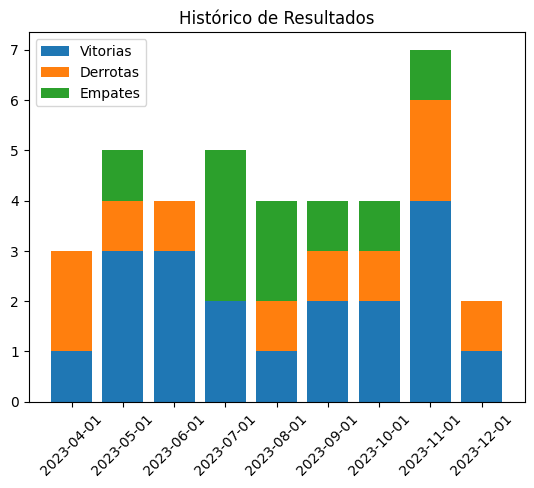

,partida_id,data,mandante,visitante,tecnico_visitante,tecnico_mandante,mandante_Placar,visitante_Placar,arena,formacao_mandante,...,ano,mes,mensal_overview,resultado,oponente,cont_partidas,cont_empates,cont_vitorias,cont_derrotas,tecnico
590,6127,14/04/2018,Vitoria,Flamengo,M. Nogueira Barbieri,V. Carmo Mancini,2,2,Barradão,4-2-3-1,...,2018,4,2018-04-01,Empate,Vitoria,1,1,0,0,M. Nogueira Barbieri
591,6137,21/04/2018,Flamengo,America-MG,E. Alves Moreira,M. Nogueira Barbieri,2,0,Maracanã,4-1-4-1,...,2018,4,2018-04-01,Vitoria,America-MG,1,0,1,0,M. Nogueira Barbieri
592,6148,29/04/2018,Ceara,Flamengo,M. Nogueira Barbieri,M. Oliveira Chamusca,0,3,Arena Castelão,3-4-2-1,...,2018,4,2018-04-01,Vitoria,Ceara,1,0,1,0,M. Nogueira Barbieri
593,6159,06/05/2018,Flamengo,Internacional,O. Hellmann,M. Nogueira Barbieri,2,0,Maracanã,4-1-4-1,...,2018,5,2018-05-01,Vitoria,Internacional,1,0,1,0,M. Nogueira Barbieri
594,6172,13/05/2018,Chapecoense,Flamengo,M. Nogueira Barbieri,G. Kleina,3,2,Arena Condá,4-1-4-1,...,2018,5,2018-05-01,Derrota,Chapecoense,1,0,0,1,M. Nogueira Barbieri
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
813,8325,23/11/2023,Flamengo,Bragantino,P. Faria Caixinha,A. Bacchi,1,0,Maracanã,4-2-3-1,...,2023,11,2023-11-01,Vitoria,Bragantino,1,0,1,0,A. Bacchi
814,8371,26/11/2023,America-MG,Flamengo,A. Bacchi,D. Giacomini,0,3,Estádio Municipal Parque do Sabiá,4-2-3-1,...,2023,11,2023-11-01,Vitoria,America-MG,1,0,1,0,A. Bacchi
815,8378,29/11/2023,Flamengo,Atletico-MG,L. Scolari,A. Bacchi,0,3,Maracanã,4-2-3-1,...,2023,11,2023-11-01,Derrota,Atletico-MG,1,0,0,1,A. Bacchi
816,8388,03/12/2023,Flamengo,Cuiaba,A. Cardoso de Oliveira,A. Bacchi,2,1,Maracanã,4-2-3-1,...,2023,12,2023-12-01,Vitoria,Cuiaba,1,0,1,0,A. Bacchi


In [26]:
vitorias   = (
                df_fla_placar
                .query('mensal_overview >= "2023-01-01"')
                [['cont_vitorias','mensal_overview']]
                .groupby('mensal_overview')
                .agg('sum')
                .reset_index()
                .drop(['mensal_overview'], axis = 1)
            )

derrotas   = (
                df_fla_placar
                .query('mensal_overview >= "2023-01-01"')
                [['cont_derrotas','mensal_overview']]
                .groupby('mensal_overview')
                .agg('sum')
                .reset_index()
                .drop(['mensal_overview'], axis = 1)
            )

empates   = (
                df_fla_placar
                .query('mensal_overview >= "2023-01-01"')
                [['cont_empates','mensal_overview']]
                .groupby('mensal_overview')
                .agg('sum')
                .reset_index()
                .drop(['mensal_overview'], axis = 1)
            )

# sns.set_style("whitegrid")

categorias = (
                df_fla_placar
                .query('mensal_overview >= "2023-01-01"')
                ['mensal_overview']
                .astype(str)
                .drop_duplicates()
             )

# Definir as posições das barras (eixo X)

# Criar gráfico de barras empilhadas
plt.bar(categorias, vitorias['cont_vitorias'], label='Vitorias', color=sns.color_palette()[0])
plt.bar(categorias, derrotas['cont_derrotas'], bottom=vitorias['cont_vitorias'], label='Derrotas', color=sns.color_palette()[1])
plt.bar(categorias, empates['cont_empates'], bottom=vitorias['cont_vitorias'] + derrotas['cont_derrotas'], label='Empates', color=sns.color_palette()[2])

# Adicionar legendas e títulos

plt.title('Histórico de Resultados')
plt.legend()
plt.xticks(rotation=45)
plt.grid(False)

# Exibir o gráfico
plt.show()
df_fla_placar

# ANALISANDO OS RESULTADOS POR TECNICO E POR TIME


In [34]:
# SETANDO OS DFS PARA VER OS NÚMEROS DO FLAMENGO COM MANDANTE E COMO VISITANTE

df_fla_visitante = df_fla_placar[df_fla_placar['visitante'] == 'Flamengo']
df_fla_mandante = df_fla_placar[df_fla_placar['mandante'] == 'Flamengo']

df_fla_visitante_overview = df_fla_visitante.groupby('visitante')[['cont_derrotas', 'cont_vitorias', 'cont_empates']].agg('sum')
df_fla_mandante_overview = df_fla_mandante.groupby('mandante')[['cont_derrotas', 'cont_vitorias', 'cont_empates']].agg('sum')

# df_fla_visitante_overview
df_fla_mandante_overview

,cont_derrotas,cont_vitorias,cont_empates
mandante,,,
Flamengo,21,76,17


In [28]:
# ANALISANDO RESULTADOS DO FLAMENGO POR TIME

df_fla_resultados_times = (
                            df_fla_placar
                            .groupby('oponente')
                            [['cont_derrotas','cont_vitorias', 'cont_empates','cont_partidas']]
                            .agg('sum')
                            .reset_index()
                            .sort_values(by = ['cont_vitorias','cont_partidas'], ascending = False)
                            .rename(columns = {"cont_vitorias":"Vitórias", "cont_derrotas": "Derrotas", "cont_empates":"Empates", "cont_partidas": "Partidas"})
                          )

df_fla_resultados_times = df_fla_resultados_times.assign(percentual_vitorias = (df_fla_resultados_times['Vitórias']/df_fla_resultados_times['Partidas'])*100)

df_fla_resultados_times

,oponente,Derrotas,Vitórias,Empates,Partidas,percentual_vitorias
11,Corinthians,2,8,2,12,66.666667
23,Santos,3,8,1,12,66.666667
5,Bahia,1,8,1,10,80.000000
16,Fortaleza,2,7,1,10,70.000000
3,Atletico-MG,6,6,0,12,50.000000
21,Palmeiras,0,6,6,12,50.000000
6,Botafogo-RJ,3,6,1,10,60.000000
15,Fluminense,4,5,3,12,41.666667
18,Gremio,3,5,2,10,50.000000
0,America-MG,0,5,3,8,62.500000


In [33]:
# ANALISANDO RESULTADOS DO TIME POR TÉCNICO

df_fla_resultados_tecnico = (
    df_fla_placar
    .groupby('tecnico')
    [['cont_vitorias','cont_derrotas','cont_empates','cont_partidas']]
    .agg('sum')
    .reset_index()
    .sort_values(by = ['cont_vitorias','cont_partidas'], ascending = False)
) 

df_fla_resultados_tecnico

,tecnico,cont_vitorias,cont_derrotas,cont_empates,cont_partidas
2,D. Silvestre Júnior,22,10,8,40
6,J. Pinheiro de Jesus,21,2,4,27
15,Renato Gaúcho,15,3,7,25
10,M. Nogueira Barbieri,14,6,6,26
14,R. Ceni,14,8,3,25
8,J. Sampaoli Moya,11,6,7,24
3,D. Torrent Font,9,5,4,18
0,A. Bacchi,7,4,1,12
13,P. Carvalho de Sousa,3,4,3,10
1,A. da Silva Braga,3,2,1,6


#  ANALISANDO OS DEMAIS DADOS

In [59]:
# df_fla_stats
# df_fla_gols
df_fla_cards = (
    df_fla_cards
    .assign(cartao_vermelho = np.where(df_fla_cards['cartao'] == 'Vermelho',1,0))
    .assign(cartao_amarelo = np.where(df_fla_cards['cartao'] == 'Amarelo',1,0))
    .assign(qtd_cards = 1)
)
df_fla_cards_atletas = (
                            df_fla_cards
                            .groupby('posicao')
                            [['cartao_vermelho','cartao_amarelo','qtd_cards']]
                            .agg('sum')
                            .sort_values(by = 'qtd_cards', ascending=False)
                            .reset_index()
                        )

df_fla_cards_atletas.head()

,posicao,cartao_vermelho,cartao_amarelo,qtd_cards
0,Meio-campo,19,350,369
1,Zagueiro,8,274,282
2,Atacante,11,126,137
3,Goleiro,3,20,23
